In [4]:
##############################################################################################################
### Example notebook for continuous time -- (un)conditional or guided -- diffusion in continuous spaces
##############################################################################################################

# Import public modules
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from sklearn.datasets import make_swiss_roll

# Import custom modules
from src import datasets
from src import managers
from src import continuous_models

In [5]:
## Define some utility functions
def plot_data_distr(x, y=None, title=None, lims=None, ax=None):
    """ Plot the data distribution. """
    # Define some plot specs
    alpha_plot = 0.5
    colors_list = ['r', 'b', 'forestgreen', 'orange']

    show_fig = False
    if ax is None:
        show_fig = True
        plt.figure(figsize=(6, 6))
        ax = plt.gca()

    # Handle the y input
    if y is None:
        # Do the scatter plot
        ax.scatter(x[:, 0], x[:, 1], alpha=alpha_plot, color='hotpink')
    else:
        if isinstance(y, (float, int)):
            y = y*np.ones(x.shape[0])
            
        # Generate the colors array    
        colors = np.array([colors_list[int(y[ix])] for ix in range(y.shape[0])])

        # Do the scatter plot        
        ax.scatter(x[:, 0], x[:, 1], alpha=alpha_plot, color=colors)

    if lims is not None:
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        # Set plot specs
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')

    if show_fig:
        plt.show()


def plot_data_distr_for_diff_noise(X_data, diffusion_manager):
    """ Plot the data distribution for different noise values. """
    # Plot the unoised (ground truth) distribution
    plot_data_distr(X_data)

    # Loop over t
    for t in [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]:
        x_noised = diffusion_manager.forward_sample_z_t(torch.tensor(X_data), t=t)
        plot_data_distr(x_noised, title=f"t={t}")


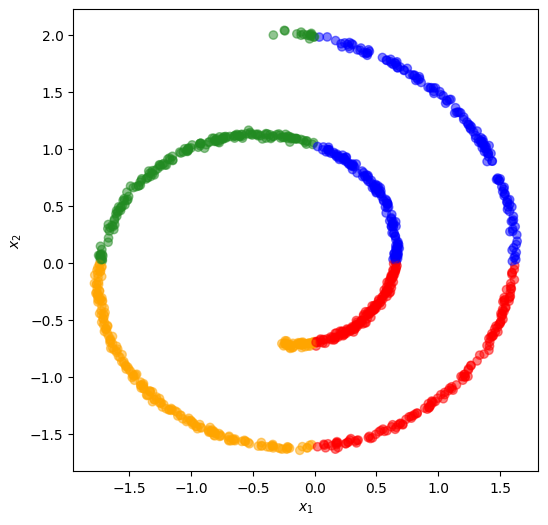

In [7]:
################################################################################
### Create a dataset with two continuous features
################################################################################
# Generate a Swiss-roll dataset
# Remark: X will have shape (#datapoints, 3)
num_datapoints = 1000 #10000
X, y = make_swiss_roll(n_samples=num_datapoints, noise=0.1, random_state=42)
X = sklearn.preprocessing.StandardScaler().fit_transform(X)

# The Swiss-roll is in the first and third axis, thus only keep these two
# for X_data, which will be of shape (#datapoints, 2)
X_data = np.stack([X[:, 0], X[:, 2]]).T

# Determine classes as y values
y_data     = np.zeros(X_data.shape[0])
ix         = np.where(np.logical_and(0<X_data[:, 0], 0<X_data[:, 1]))
y_data[ix] = 1
ix         = np.where(np.logical_and(X_data[:, 0]<=0, 0<X_data[:, 1]))
y_data[ix] = 2
ix         = np.where(np.logical_and(X_data[:, 0]<=0, X_data[:, 1]<=0))
y_data[ix] = 3
# y     = np.zeros(X_data.shape[0])
# ix    = np.where(1<=np.sum(X_data**2, axis=1))
# y[ix] = 1
# ix    = np.where(3<=np.sum(X_data**2, axis=1))
# y[ix] = 2
# ix    = np.where(4<=np.sum(X_data**2, axis=1))
# y[ix] = 3
# # ix    = np.where(np.logical_and(X_data[:, 0]<=0, X_data[:, 1]<=0))
# # y[ix] = 3

# # Define colors
# colors_data = np.array([colors_list[int(y_data[ix])] for ix in range(y_data.shape[0])])

plot_data_distr(X_data, y_data)

Training the 'denoising' model for '1000' epochs.
[0] 1049.7867431640625
[100] 332.467529296875
[200] 323.1772155761719
[300] 260.58697509765625
[400] 225.00924682617188
[500] 258.3180847167969
[600] 252.6919403076172
[700] 272.7833557128906
[800] 238.67112731933594
[900] 263.9866638183594


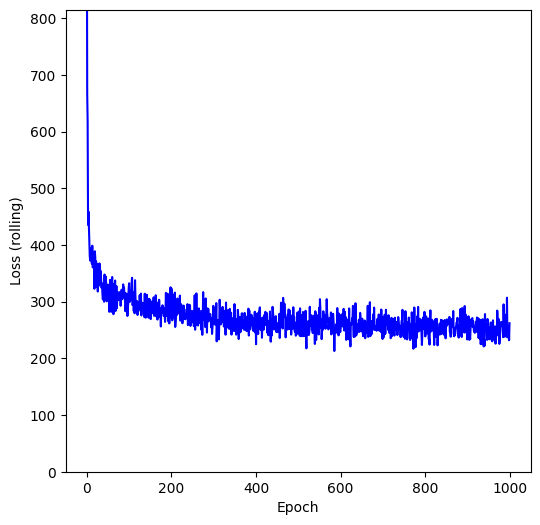

Last (rolling epoch) loss: 262.03826904296875


In [10]:
# Reload custom modules
reload(datasets)
reload(managers)
reload(continuous_models)

# Define scenarios
use_conditional_diffusion = True
use_guided_diffusion      = False

##########################################################################################################
### 1) Define the denoising model differing the cases where we want to use conditional diffusion or not
##########################################################################################################
torch.random.manual_seed(20)
if use_conditional_diffusion:
    # Throw an error if the guided Flag is True (i.e. we either use conditional diffusion or guided diffusion based on an unconditional noise model)
    if use_guided_diffusion:
        err_msg = f"Either do (unguided) diffusion with a conditional denoising model, or do guided diffusion with an unconditional denoising model. Thus, 'unuse_conditional_diffusion=False' and 'use_guided_diffusion=True' is not allowed."

    # Define a conditional denoising model
    denoising_model = continuous_models.ConditionalDenoisingModel(x_dim=2, t_dim=1, y_dim=4, lat_dim=200)
else:
    # Use an unconditional denoising model
    denoising_model = continuous_models.DenoisingModel(x_dim=2, t_dim=1, lat_dim=200)

# Define an optimizer for the model parameters of the denoising model
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.01) #0.01

##########################################################################################################
### 2) Define the diffusion manager differing the cases where we want to use guided diffusion or not
##########################################################################################################
if use_guided_diffusion:
    ## Use guided diffusion (with unconditional denoising model) that uses a property model

    # Initialize the property model if we want to use guided diffusion
    torch.random.manual_seed(21)
    property_model = continuous_models.PropertyModel(x_dim=2, t_dim=1, y_dim=4, lat_dim=10)

    # Define an optimizer for the model parameters of the property model (used for guidance)
    property_optimizer  = torch.optim.Adam(property_model.parameters(), lr=0.01) #0.01

    # Define a diffusion manager object
    torch.random.manual_seed(72)
    diffusion_manager = managers.ContinuousDiffusionManager(denoising_model, denoising_optimizer, property_model, property_optimizer)
else:
    ## Use unguided diffusion (with unconditional denoising model)
    # Define a diffusion manager object
    torch.random.manual_seed(72)
    diffusion_manager = managers.ContinuousDiffusionManager(denoising_model, denoising_optimizer)


##########################################################################################################
### 3) Do some diagnostics concerning the noise (schedule)
##########################################################################################################
# Show the noise schedule
#diffusion_manager.show_noise_schedule()

# Plot the data distribution for different noise values
#plot_data_distr_for_diff_noise(X_data, diffusion_manager)

##########################################################################################################
### 4) Model training
##########################################################################################################
# Define the training dataset and a dataloader
train_dataset    = datasets.DictDataset(x=torch.tensor(X_data, dtype=torch.float32), y=torch.tensor(y_data, dtype=torch.int))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=X_data.shape[0], shuffle=True)

# Train the denoising model
diffusion_manager.train(train_dataloader, which_model='denoising', num_epochs=1000)


# Train the property model if we use guided diffusion
if use_guided_diffusion:
    diffusion_manager.train(train_dataloader, which_model='property', num_epochs=1000)



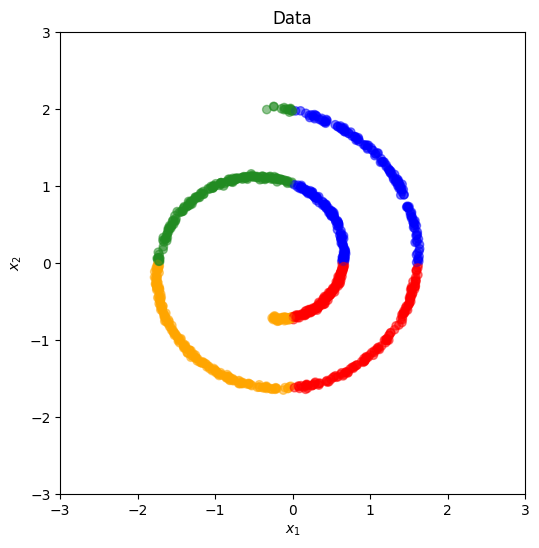

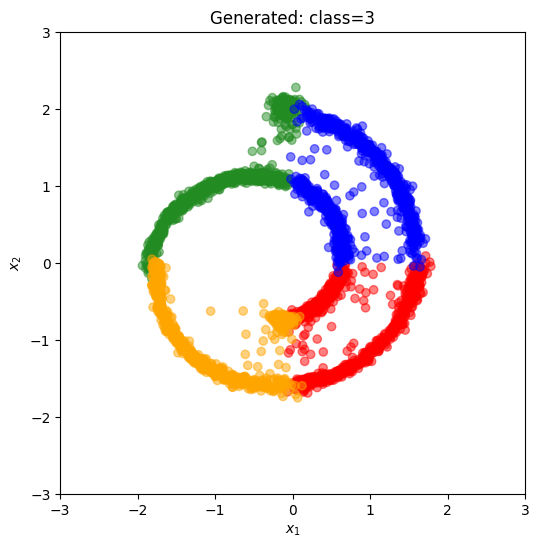

In [12]:
# Plot the data distribution
plot_data_distr(X_data, y=y_data, title=f"Data", lims=[-3, 3])

# Plot conditional distribution (generated)
plt.figure(figsize=(6, 6))
ax = plt.gca()
for ind_1 in range(2):
    for ind_2 in range(2):
        y = ind_1 + 2*ind_2
        X_generated = diffusion_manager.generate(num_time_steps=100, batch_size=1000, random_seed=99, y=y)
        plot_data_distr(X_generated.cpu().detach().numpy(), y=y, title=f"Generated: class={y}", lims=[-3, 3], ax=ax)

